# AIRBNB SEATTLE
This is an explanatory journey of the data provided by Airbnb seattle.

# Questions I Believe worth Exploring

1. What are the most important features that affect the host revenue?
2. What is th emost popular neighborhood?
3. What is th emost popular type of property rental?
4. What are the most popular words that attract customers?

## Importing the needed libraries

In [1]:
# Import the needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import re
from sklearn.preprocessing import StandardScaler

## Importing Data

In [5]:
# Import the required dataset
seattle_cal = pd.read_csv('Data/AirBnB/seattle/calendar.csv')
seattle_list = pd.read_csv('Data/AirBnB/seattle/listings.csv')
seattle_rev = pd.read_csv('Data/AirBnB/seattle/reviews.csv')

In [6]:
# This function enables the me to see all the columns in the dataframe
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [7]:
display_all(seattle_list.head())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [8]:
# There are 92 variables in the listing dataset with 3818 observations 
seattle_list.shape

(3818, 92)

In [9]:
seattle_list.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Looking at the listing file, we see 92 variables with 3,818 records

In [169]:
df_raw = seattle_list.copy()

## Data Cleansing

In [170]:
def remove_symbols(df, col):
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].str.replace(',', '').astype(float)
    df[col].fillna(0, inplace=True)

In [171]:
def remove_perc(df, col):
    df[col] = df[col].str.replace('%', '').astype(float)
    df[col].fillna(0, inplace=True)

In [172]:
def clean_row(df):
    # Convert the values with "$" to  and fill nulls with zero as this shall be free of charge or not available
    remove_symbols(df, 'price')
    remove_symbols(df, 'extra_people')
    remove_symbols(df, 'security_deposit')
    remove_symbols(df, 'cleaning_fee')
    remove_perc(df, 'host_acceptance_rate')
    remove_perc(df, 'host_response_rate')
    remove_symbols(df, 'monthly_price')
    remove_symbols(df, 'weekly_price')

In [173]:
clean_row(df_raw)

In [174]:
df_raw.shape

(3818, 92)

In [175]:
def clean_col(df):
    # Check for columns with same value in every record
    empty_cols = []
    for col in df.columns:
        if np.all(df.groupby(col).id.count() == 3818):
            empty_cols.append(col)
    df.drop(empty_cols, axis=1, inplace=True)
    
    # Drop variables with URL as these are unique to each record and holds little value
    col_url = df.columns[df.columns.str.contains('_url')]
    df.drop(col_url, axis=1, inplace=True)


In [176]:
clean_col(df_raw)

In [177]:
df_raw.shape

(3818, 73)

In [178]:
# This finction will encode columns to check if any has the same value but in different form
def drop_duplicates(df):
    factor_df =  pd.DataFrame()

    for col in df.columns:
        factor_df[col] = df[col].factorize()[0]
        
    dupl_dict = {}
    for index, col_1 in enumerate(factor_df.columns):
        for col_2 in factor_df.columns[index + 1:]:
            if np.all(factor_df[col_1] == factor_df[col_2]):
                dupl_dict[col_1] = col_2
    return dupl_dict

In [179]:
drop_duplicates(df_raw)

{'id': 'longitude',
 'host_listings_count': 'host_total_listings_count',
 'city': 'smart_location',
 'latitude': 'longitude'}

Columns city and host_listings_count can be dropped easily as they are duplicates

In [180]:
df_raw.drop(['host_listings_count', 'city'], axis=1, inplace=True)

In [181]:
#     # Manually inspect the drop duplicate function and drop the below 2 columns
#     df.drop(['smart_location', 'host_total_listings_count'], axis=1, inplace=True)
    
#     # Drop some variables that upon eyeballing looks useless
#     df.drop(['state', 'city', 'neighbourhood', 'latitude', 'longitude'], axis=1, inplace=True)
    
#     # Fix the error in this specific ZipCode manually
#     df.loc[df.zipcode == '99\n98122', 'zipcode'] = '98122'
    
#     # Drop all the rest from street as they are visible in other variables like ZipCode
#     df.street = df.street.str.split(',', expand=True)[0]
    
#     # I will drop this variable because its content and that of the neighbourhood_cleansed is the same with less details
#     df.drop('host_neighbourhood', axis=1, inplace=True)
    
#         # Drop variables with high number of Null values more than 75%
#     null_value = df.columns[df.isnull().sum()/len(df) > .75]
#     df.drop(['square_feet'], axis=1,inplace=True)

In [182]:
display_all(df_raw.head())

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96.0,100.0,f,Queen Anne,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,WA,98119,"Seattle, WA",47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,85.0,0.0,0.0,0.0,0.0,2,5.0,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98.0,100.0,t,Queen Anne,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,WA,98119,"Seattle, WA",47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67.0,100.0,f,Queen Anne,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,WA,98119,"Seattle, WA",47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,975.0,0.0,0.0,1000.0,300.0,10,25.0,4,30,5 weeks ago,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,0.0,0.0,f,Queen Anne,1.0,"['email', 'phone', 'facebook'

In [183]:
df_raw.isnull().sum().sort_values(ascending=False)[:20]

square_feet                    3721
notes                          1606
neighborhood_overview          1032
transit                         934
host_about                      859
review_scores_checkin           658
review_scores_accuracy          658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
first_review                    627
reviews_per_month               627
last_review                     627
space                           569
host_response_time              523
neighbourhood                   416
host_neighbourhood              300
summary                         177
dtype: int64

In [184]:
df_raw.columns

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'host_id', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'state', 'zipcode', 'smart_location',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'avail

In [185]:
df_raw.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [186]:
df_raw.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [187]:
df_raw.availability_365.sort_values(ascending=False).head(10)

1446    365
1995    365
1194    365
1188    365
3053    365
1187    365
3051    365
1186    365
3048    365
1991    365
Name: availability_365, dtype: int64

In [188]:
df_raw.availability_365.sort_values(ascending=False).tail(10)

2961    0
1800    0
1857    0
2955    0
2935    0
2929    0
1955    0
1980    0
2852    0
384     0
Name: availability_365, dtype: int64

It is really stange that some properties are not available at all, why listed?

In [189]:
display_all(df_raw[df_raw.availability_365 == 0].head())

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
142,4550099,Brand-New 3BR/3BA Home w/ Roof-View,Brand-new 3BR/3BA townhome in the Ballard neig...,"Brand-new, 3-story, 3BR/3BA townhome with mode...",Brand-new 3BR/3BA townhome in the Ballard neig...,Located two blocks from a 15 minute Rapid Ride...,NaN,The Rapid Ride D-line picks up two blocks from...,15104715,Mike & Laura,2014-05-04,"Seattle, Washington, United States",We are newlyweds who moved from California to ...,NaN,0.0,0.0,f,Ballard,1.0,"['email', 'phone', 'facebook', 'google', 'link...",t,t,"Northwest 62nd Street, Seattle, WA 98107, Unit...",Ballard,West Woodland,Ballard,WA,98107,"Seattle, WA",47.674333,-122.375678,t,House,Entire home/apt,6,3.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,295.0,0.0,0.0,300.0,131.0,5,50.0,2,7,3 months ago,0,0,0,0,3,2014-11-29,2015-05-26,93.0,9.0,7.0,9.0,10.0,9.0,8.0,f,strict,f,f,1,0.22
297,1030411,Classic Seattle/Wallingford Home,Fantastic location! Bright and open remodeled ...,Our classic craftsman home is in the Wallingfo...,Fantastic location! Bright and open remodeled ...,"Wallingford is a central, walkable neighborhoo...",We have two friendly cats who live in the hous...,There are several bus lines within a few block...,365852,Kymber,2011-01-28,"Seattle, Washington, United States",Jay is a linguist and program manager at Micro...,NaN,0.0,0.0,f,Wallingford,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"North 49th Street, Seattle, WA 98103, United S...",Wallingford,Wallingford,Other neighborhoods,WA,98103,"Seattle, WA",47.665402,-122.339387,t,House,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Free Pa...",2100.0,200.0,0.0,0.0,0.0,100.0,1,0.0,3,14,6 months ago,0,0,0,0,3,2014-06-22,2014-12-28,100.0,10.0,10.0,9.0,10.0,10.0,10.0,f,strict,f,f,1,0.16
324,4122325,Spacious 3bd/2ba Green Lake Home,Our comfortable and stylish home is a short wa...,Our home has an open floor plan on the main fl...,Our comfortable and stylish home is a short wa...,Green Lake is a beautiful neighborhood in the ...,We do have a big friendly dog. She travels wit...,"Easy access to Wallingford, Fremont, Ballard, ...",17961308,Ryan,2014-07-11,"Seattle, Washington, United States",My wife and I live in the Green Lake neighborh...,within a few hours,100.0,100.0,t,Green Lake,1.0,"['email', 'phone', 'linkedin', 'reviews', 'jum...",t,t,"5th Avenue Northeast, Seattle, WA 98115, Unite...",Green Lake,Wallingford,Other neighborhoods,WA,98115,"Seattle, WA",47.672062,-122.324928,t,House,Entire home/apt,5,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,175.0,0.0,0.0,100.0,0.0,5,0.0,2,14,5 weeks ago,0,0,0,0,26,2014-10-26,2015-11-15,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,f,f,1,1.79
368,6765045,Charming 3BR home in Wallingford,Ground floor unit in historic craftsman duplex...,Ground floor unit in historic craftsman house ...,Ground 

In [190]:
df_raw.amenities.unique()

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}',
       '{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}',
       ...,
       '{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises",Breakfast,"Pets live on this property",Dog(s),Cat(s),Heating,Washer,Dryer,"Smoke Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials,Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}',
       '{TV,"Wireless I

In [191]:
df_pred = df_raw[['id', 'host_name', 'host_response_time', 'host_acceptance_rate','host_response_rate',
                  'host_is_superhost', 'host_verifications','host_has_profile_pic', 'host_identity_verified', 
                  'neighbourhood_cleansed', 
                  'is_location_exact', 'property_type', 'room_type', 'accommodates',
                  'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
                  'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
                  'minimum_nights','availability_365', 'number_of_reviews', 'review_scores_rating',
                  'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication',
                  'review_scores_location', 'review_scores_value', 'instant_bookable',
                  'cancellation_policy', 'require_guest_profile_picture', 'calculated_host_listings_count', 
                  'reviews_per_month']].copy()

# Feature Engineering

In [192]:
def host_name(df):
    # Treating host name
    # The host name doesnt look a lot but upon checking them I noticed that there are singles and couples 
    # hosts which makes it interesting to see if such a variable affects a person decisions
    pattern = '&|And '
    conditions = [(df.host_name.str.contains(pattern) == True), (df.host_name.str.contains(pattern) == False)]
    choices = ['Couple', 'Singles']
    df['host_type'] = np.select(conditions, choices)
    df.drop(['host_name'], axis=1, inplace=True)

In [193]:
host_name(df_pred)

In [194]:
display_all(df_pred.head())

,id,host_response_time,host_acceptance_rate,host_response_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,calculated_host_listings_count,reviews_per_month,host_type
0,241032,within a few hours,100.0,96.0,f,"['email', 'phone', 'reviews', 'kba']",t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,2,4.07,Singles
1,953595,within an hour,100.0,98.0,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,6,1.48,Singles
2,3308979,within a few hours,100.0,67.0,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,West Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,2,1.15,Singles
3,7421966,NaN,0.0,0.0,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,West Queen Anne,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,0.0,0.0,1,0.0,1,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,1,NaN,Singles
4,278830,within an hour,0.0,100.0,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,West Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,1,0.89,Singles


In [195]:
def host_verify(df):
    # Extracting variables from Host Verfication
    # I decided to create dummy variables from host verifications because keeping them in lists will 
    #dillute the value of each communiction channel
    vectorizer = CountVectorizer()
    tk_count = vectorizer.fit_transform(df['host_verifications'])
    contact_list = vectorizer.get_feature_names()
    
    contact_df = pd.DataFrame(tk_count.toarray(), columns=vectorizer.get_feature_names())
    
    for col in contact_df:
        df[col+'_WC_'+ str(col)] = contact_df[col]
        
    # Drop the existing variable      
    df.drop('host_verifications', axis=1, inplace=True)

In [196]:
host_verify(df_pred)

In [197]:
display_all(df_pred.head())

,id,host_response_time,host_acceptance_rate,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,calculated_host_listings_count,reviews_per_month,host_type,amex_WC_amex,email_WC_email,facebook_WC_facebook,google_WC_google,jumio_WC_jumio,kba_WC_kba,linkedin_WC_linkedin,manual_offline_WC_manual_offline,manual_online_WC_manual_online,none_WC_none,phone_WC_phone,photographer_WC_photographer,reviews_WC_reviews,sent_id_WC_sent_id,weibo_WC_weibo
0,241032,within a few hours,100.0,96.0,f,t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,2,4.07,Singles,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
1,953595,within an hour,100.0,98.0,t,t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,6,1.48,Singles,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0
2,3308979,within a few hours,100.0,67.0,f,t,t,West Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,2,1.15,Singles,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0
3,7421966,NaN,0.0,0.0,f,t,t,West Queen Anne,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,0.0,0.0,1,0.0,1,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,1,NaN,Singles,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0
4,278830,within an hour,0.0,100.0,f,t,t,West Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,1,0.89,Singles,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0


In [198]:
df_pred.amenities[:10]

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
5    {"Wireless Internet","Free Parking on Premises...
6    {"Wireless Internet","Free Parking on Premises...
7    {"Wireless Internet","Pets live on this proper...
8    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
9    {TV,Internet,"Wireless Internet",Kitchen,"Free...
Name: amenities, dtype: object

In [199]:
amenities_list = []
for index, row in df_pred.iterrows():
    amenities = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', ' ', row['amenities']).strip()
    amenities_list.append(amenities)
df_pred['amenities'] = amenities_list    

In [200]:
df_pred['amenities'].head(10)

0    TV  Cable TV  Internet  Wireless Internet   Ai...
1    TV Internet  Wireless Internet  Kitchen  Free ...
2    TV  Cable TV  Internet  Wireless Internet   Ai...
3    Internet  Wireless Internet  Kitchen  Indoor F...
4    TV  Cable TV  Internet  Wireless Internet  Kit...
5    Wireless Internet   Free Parking on Premises  ...
6    Wireless Internet   Free Parking on Premises  ...
7    Wireless Internet   Pets live on this property...
8    TV  Cable TV  Internet  Wireless Internet  Kit...
9    TV Internet  Wireless Internet  Kitchen  Free ...
Name: amenities, dtype: object

In [201]:
vectorizer = CountVectorizer(ngram_range=(1,5),max_features=150) 
amenities_features = vectorizer.fit_transform(df_pred['amenities'])
amenities_df = pd.DataFrame(amenities_features.toarray(), columns=vectorizer.get_feature_names())

In [202]:
vectorizer.get_feature_names()

['aid',
 'aid kit',
 'aid kit fire',
 'aid kit fire extinguisher',
 'building',
 'cable',
 'cable tv',
 'cable tv internet',
 'cable tv internet wireless',
 'cable tv internet wireless internet',
 'carbon',
 'carbon monoxide',
 'carbon monoxide detector',
 'carbon monoxide detector first',
 'carbon monoxide detector first aid',
 'detector',
 'detector carbon',
 'detector carbon monoxide',
 'detector carbon monoxide detector',
 'detector carbon monoxide detector first',
 'detector first',
 'detector first aid',
 'detector first aid kit',
 'detector first aid kit fire',
 'dryer',
 'dryer smoke',
 'dryer smoke detector',
 'dryer smoke detector carbon',
 'dryer smoke detector carbon monoxide',
 'elevator',
 'elevator in',
 'elevator in building',
 'essentials',
 'essentials shampoo',
 'extinguisher',
 'extinguisher essentials',
 'extinguisher essentials shampoo',
 'family',
 'family kid',
 'family kid friendly',
 'family kid friendly washer',
 'family kid friendly washer dryer',
 'fire',
 

In [114]:
amenities_df.drop(['aid',
 'aid kit',
 'aid kit extinguisher',
 'aid kit extinguisher essentials',
 'air',
 'building',
 'cable',
 'cable tv internet',
 'cable tv internet wireless',
 'cable tv internet wireless internet',
 'carbon',
 'carbon monoxide',
 'carbon monoxide detector aid',
 'carbon monoxide detector aid kit',
 'card',
 'card extinguisher',
 'conditioning',
 'detector',
 'detector aid',
 'detector aid kit',
 'detector aid kit extinguisher',
 'detector aid kit extinguisher essentials',
 'detector carbon',
 'detector carbon monoxide',
 'detector carbon monoxide detector',
 'detector carbon monoxide detector aid',
 'detector essentials',
 'detector extinguisher',
 'dryer',
 'dryer smoke',
 'dryer smoke detector',
 'dryer smoke detector carbon',
 'dryer smoke detector carbon monoxide',
 'elevator building',
 'essentials',
 'essentials shampoo',
 'extinguisher',
 'extinguisher essentials',
 'extinguisher essentials shampoo',
 'family',
 'family kid',
 'family kid friendly',
 'family kid friendly washer',
 'family kid friendly washer dryer',
 'fireplace',
 'fireplace heating',
 'free',
 'free parking',
 'free parking premises',
 'free parking premises pets',
 'friendly',
 'friendly washer',
 'friendly washer dryer',
 'friendly washer dryer smoke',
 'friendly washer dryer smoke detector',
 'friendly workspace',
 'hair',
 'hair dryer',
 'hangers',
 'hangers hair',
 'hangers hair dryer',
 'heating',
 'heating family',
 'heating family kid',
 'heating family kid friendly',
 'heating family kid friendly washer',
 'heating washer',
 'heating washer dryer',
 'heating washer dryer smoke',
 'heating washer dryer smoke detector',
 'indoor',
 'indoor fireplace',
 'indoor fireplace heating',
 'internet',
 'internet air',
 'internet air conditioning',
 'internet kitchen',
 'internet kitchen free',
 'internet kitchen free parking',
 'internet kitchen free parking premises',
 'internet wireless',
 'internet wireless internet',
 'internet wireless internet kitchen',
 'internet wireless internet kitchen free',
 'iron',
 'kid',
 'kid friendly',
 'kid friendly washer',
 'kid friendly washer dryer',
 'kid friendly washer dryer smoke',
 'kit',
 'kit extinguisher',
 'kit extinguisher essentials',
 'kitchen',
 'kitchen free',
 'kitchen free parking',
 'kitchen free parking premises',
 'laptop',
 'laptop friendly',
 'laptop friendly workspace',
 'live',
 'live property',
 'monoxide',
 'monoxide detector',
 'monoxide detector aid',
 'monoxide detector aid kit',
 'parking',
 'parking premises',
 'parking premises pets',
 'pets',
 'pets live',
 'pets live property',
 'premises',
 'premises pets',
 'property',
 'safety',
 'safety card',
 'safety card extinguisher',
 'shampoo',
 'smoke',
 'smoke detector',
 'smoke detector carbon',
 'smoke detector carbon monoxide',
 'smoke detector carbon monoxide detector',
 'tv',
 'tv cable',
 'tv cable tv',
 'tv cable tv internet',
 'tv cable tv internet wireless',
 'tv internet',
 'tv internet wireless',
 'tv internet wireless internet',
 'tv internet wireless internet kitchen',
 'washer',
 'washer dryer',
 'washer dryer smoke',
 'washer dryer smoke detector',
 'washer dryer smoke detector carbon',
 'wireless',
 'wireless internet',
 'wireless internet air',
 'wireless internet air conditioning',
 'wireless internet kitchen',
 'wireless internet kitchen free',
 'wireless internet kitchen free parking',
 'workspace'], axis=1, inplace=True)

,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,...,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,2,1,0,1,0
1,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,1,0,2,0
2,0,0,0,1,1,0,0,0,0,1,...,1,1,0,0,1,2,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,1,...,1,1,0,0,0,2,0,0,1,0


In [545]:
df = treat_amenities(df_pred, 'amenities')

In [546]:
df.drop('index', axis=1, inplace=True)

In [547]:
df.shape

(3818, 119)

In [548]:
display_all(df.head())

,id,host_response_time,host_acceptance_rate,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,monthly_price_cat,weekly_price_cat,calculated_host_listings_count,host_type,amex_WC_amex,email_WC_email,facebook_WC_facebook,google_WC_google,jumio_WC_jumio,kba_WC_kba,linkedin_WC_linkedin,manual_offline_WC_manual_offline,manual_online_WC_manual_online,none_WC_none,phone_WC_phone,photographer_WC_photographer,reviews_WC_reviews,sent_id_WC_sent_id,weibo_WC_weibo,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,carbon,card,cat,check,conditioning,detector,dog,door,doorman,dryer,elevator,essentials,events,extinguisher,family,fireplace,free,friendly,gym,hair,hangers,heating,hot,hour,indoor,intercom,internet,iron,kid,kit,kitchen,laptop,live,lock,monoxide,parking,pet,pets,pool,premises,property,safety,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace
0,241032,within a few hours,100.0,96.0,f,3.0,t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,85.0,0.0,0.0,2,5.0,1,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,no,no,2,Singles,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0
1,953595,within an hour,100.0,98.0,t,6.0,t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,150.0,100.0,40.0,1,0.0,2,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,yes,yes,6,Singles,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,1,2,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,2,0
2,3308979,within a few hours,100.0,67.0,f,2.0,t,t,West Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7,Real Bed,975.0,1000.0,300.0,10,25.0,4,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,no,no,2,Singles,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,2,1,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,1,0,1,0,2,0,1,0,1,0,1,0,1,1,0,2,0,1,1,0,1,1,0,0,1,2,1,0,1,0
3,7421966,0,0.0,0.0,f,1.0,t,t,West Queen Anne,t,Apartment,Entire home/apt,3,1.0,0.0,2,Real Bed,100.0,0.0,0.0,1,0.0,1,0,0,0,143,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,f,flexible,f,yes,yes,1,Singles,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0
4,278830,within an hour,0.0,100.0,f,2.0,t,t,West Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3,Real Bed,450.0,700.0,125.0,6,15.0,1,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,no,no,1,Singles,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,1,0


## Looking for a Target Variable

The closest is price, but it can't be a clear target variables because the listings we are comapring here are not the same especially in number of people it can accommodate at once

In [549]:
df.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [550]:
df.groupby('room_type').price.mean()

room_type
Entire home/apt    155.843369
Private room        75.044828
Shared room         47.547009
Name: price, dtype: float64

As visible, average price varies a lot between the different types of listings

I will assume that every review is a booking and it makes sense to include the minimum number of nights per review and multiply them by the price per note

In [551]:
def target_var(df, seattle_rev):
    # Get the reviews from year 2015 as it it is the latest data available
    seattle_rev.date = pd.to_datetime(seattle_rev.date)
    seattle_rev_2015 = seattle_rev[(seattle_rev.date >= '2015-1-1') & (seattle_rev.date < '2016-1-1')]
    
    # Groupby reviews to aggregate the reviews by listing ID
    seattle_rev_2015_df = seattle_rev_2015.groupby('listing_id').reviewer_id.count().to_frame().reset_index()
    seattle_rev_2015_df.rename(columns={'listing_id':'id', 'reviewer_id':'Number_of_Reviews_2015'}, inplace=True)
    
    # Merge with the mother df
    df = df.merge(seattle_rev_2015_df, on='id', how='left')
    df.Number_of_Reviews_2015.fillna(0, inplace=True)
    
    # Create the new target variable revenue by multiplying the price with the minimium nights per review and the number of reviews for this listing in 2015
    df['Revenue_2015'] = df.price * df.minimum_nights * df.Number_of_Reviews_2015
    
    return df

In [552]:
df = target_var(df, seattle_rev)

In [553]:
round(df['Revenue_2015'].describe(), 2)

count      3818.00
mean       3228.71
std       14534.56
min           0.00
25%         195.00
50%        1188.00
75%        3638.50
max      750000.00
Name: Revenue_2015, dtype: float64

We have a listing that generated 750,000 USD which is a probably wrong

In [554]:
df.minimum_nights.describe()

count    3818.000000
mean        2.369303
std        16.305902
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max      1000.000000
Name: minimum_nights, dtype: float64

In [555]:
# I will drop this row with 1000 minimum nights because it looks like an error in the data
df.drop(2760, inplace=True)

In [556]:
display_all(df.head())

,id,host_response_time,host_acceptance_rate,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,monthly_price_cat,weekly_price_cat,calculated_host_listings_count,host_type,amex_WC_amex,email_WC_email,facebook_WC_facebook,google_WC_google,jumio_WC_jumio,kba_WC_kba,linkedin_WC_linkedin,manual_offline_WC_manual_offline,manual_online_WC_manual_online,none_WC_none,phone_WC_phone,photographer_WC_photographer,reviews_WC_reviews,sent_id_WC_sent_id,weibo_WC_weibo,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,carbon,card,cat,check,conditioning,detector,dog,door,doorman,dryer,elevator,essentials,events,extinguisher,family,fireplace,free,friendly,gym,hair,hangers,heating,hot,hour,indoor,intercom,internet,iron,kid,kit,kitchen,laptop,live,lock,monoxide,parking,pet,pets,pool,premises,property,safety,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace,Number_of_Reviews_2015,Revenue_2015
0,241032,within a few hours,100.0,96.0,f,3.0,t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,85.0,0.0,0.0,2,5.0,1,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,no,no,2,Singles,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,68.0,5780.0
1,953595,within an hour,100.0,98.0,t,6.0,t,t,West Queen Anne,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,150.0,100.0,40.0,1,0.0,2,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,yes,yes,6,Singles,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,1,2,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,2,0,34.0,10200.0
2,3308979,within a few hours,100.0,67.0,f,2.0,t,t,West Queen Anne,t,House,Entire home/apt,11,4.5,5.0,7,Real Bed,975.0,1000.0,300.0,10,25.0,4,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,no,no,2,Singles,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,2,1,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,1,0,1,0,2,0,1,0,1,0,1,0,1,1,0,2,0,1,1,0,1,1,0,0,1,2,1,0,1,0,12.0,46800.0
3,7421966,0,0.0,0.0,f,1.0,t,t,West Queen Anne,t,Apartment,Entire home/apt,3,1.0,0.0,2,Real Bed,100.0,0.0,0.0,1,0.0,1,0,0,0,143,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,f,flexible,f,yes,yes,1,Singles,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0.0,0.0
4,278830,within an hour,0.0,100.0,f,2.0,t,t,West Queen Anne,t,House,Entire home/apt,6,2.0,3.0,3,Real Bed,450.0,700.0,125.0,6,15.0,1,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,no,no,1,Singles,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,1,0,16.0,7200.0


## Treating Categorical Variables

In [557]:
df.columns[df.dtypes == object]

Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'is_location_exact',
       'property_type', 'room_type', 'beds', 'bed_type', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'monthly_price_cat', 'weekly_price_cat', 'host_type'],
      dtype='object')

In [562]:
def encode_cat(df):
    
    # This will encode all categorical variables with 2 variables
    for col in df.columns:
        if df[col].dtype == object and len(df[col].value_counts()) == 2:
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.codes
    
    # These are the rest of the categorical variables with more than 2 levels
    cat_vars = df.columns[df.dtypes == object]
    
    df = pd.concat([df.drop(cat_vars, axis=1),\
                     pd.get_dummies(df[cat_vars], \
                                    prefix=cat_vars, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)
    return df
    
            

In [563]:
df = encode_cat(df)

In [564]:
display_all(df.head())

,id,host_acceptance_rate,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,monthly_price_cat,weekly_price_cat,calculated_host_listings_count,amex_WC_amex,email_WC_email,facebook_WC_facebook,google_WC_google,jumio_WC_jumio,kba_WC_kba,linkedin_WC_linkedin,manual_offline_WC_manual_offline,manual_online_WC_manual_online,none_WC_none,phone_WC_phone,photographer_WC_photographer,reviews_WC_reviews,sent_id_WC_sent_id,weibo_WC_weibo,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,carbon,card,cat,check,conditioning,detector,dog,door,doorman,dryer,elevator,essentials,events,extinguisher,family,fireplace,free,friendly,gym,hair,hangers,heating,hot,hour,indoor,intercom,internet,iron,kid,kit,kitchen,laptop,live,lock,monoxide,parking,pet,pets,pool,premises,property,safety,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace,Number_of_Reviews_2015,Revenue_2015,host_response_time_0,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleans

In [565]:
df.shape

(3817, 255)

## Preparing data to build a model

Since our dataframe is all encoded, we can use it to sun some model, but first we need to seperate the taregt variable and create a training/testing dataset

In [567]:
len(df)

3817

Since we used the number of reviews as the main driver in claculating revenue, if the listing had no reviews, then we are assuming they made no revenue in 2015. Since this is not entirely correct, I will drop all listings with zero revenue

In [571]:
# Remove all the lsiting with zero revenue
df = df[df.Revenue_2015 > 0].copy()

In [572]:
df.drop(['id', 'minimum_nights', 'Number_of_Reviews_2015'], axis=1, inplace=True)

In [573]:
display_all(df.head())

,host_acceptance_rate,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,price,security_deposit,cleaning_fee,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,monthly_price_cat,weekly_price_cat,calculated_host_listings_count,amex_WC_amex,email_WC_email,facebook_WC_facebook,google_WC_google,jumio_WC_jumio,kba_WC_kba,linkedin_WC_linkedin,manual_offline_WC_manual_offline,manual_online_WC_manual_online,none_WC_none,phone_WC_phone,photographer_WC_photographer,reviews_WC_reviews,sent_id_WC_sent_id,weibo_WC_weibo,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,carbon,card,cat,check,conditioning,detector,dog,door,doorman,dryer,elevator,essentials,events,extinguisher,family,fireplace,free,friendly,gym,hair,hangers,heating,hot,hour,indoor,intercom,internet,iron,kid,kit,kitchen,laptop,live,lock,monoxide,parking,pet,pets,pool,premises,property,safety,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace,Revenue_2015,host_response_time_0,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,neighbourhood_cleansed_Adams,neighbourhood_cleansed_Alki,neighbourhood_cleansed_Arbor Heights,neighbourhood_cleansed_Atlantic,neighbourhood_cleansed_Belltown,neighbourhood_cleansed_Bitter Lake,neighbourhood_cleansed_Briarcliff,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Broadview,neighbourhood_cleansed_Broadway,neighbourhood_cleansed_Bryant,neighbourhood_cleansed_Cedar Park,neighbourhood_cleansed_Central Business District,neighbourhood_cleansed_Columbia City,neighbourhood_cleansed_Crown Hill,neighbourhood_cleansed_Dunlap,neighbourhood_cleansed_East Queen Anne,neighbourhood_cleansed_Eastlake,neighbourhood_cleansed_Fairmount Park,neighbourhood_cleansed_Fauntleroy,neighbourhood_cleansed_First Hill,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Gatewood,neighbourhood_cleansed_Genesee,neighbourhood_cleansed_Georgetown,neighbourhood_cleansed_Green Lake,neighbourhood_cleansed_Greenwood,neighbourhood_cleansed_Haller Lake,neighbourhood_cleansed_Harrison/Denny-Blaine,neighbourhood_cleansed_High Point,neighbourhood_cleansed_Highland Park,neighbourhood_cleansed_Holly Park,neighbourhood_cleansed_Industrial District,neighbourhood_cleansed_Interbay,neighbourhood_cleansed_International District,neighbourhood_cleansed_Laurelhurst,neighbourhood_cleansed_Lawton Park,neighbourhood_cleansed_Leschi,neighbourhood_cleansed_Lower Queen Anne,neighbourhood_cleansed_Loyal Heights,neighbourhood_cleansed_Madison Park,neighbourhood_cleansed_Madrona,neighbourhood_cleansed_Mann,neighbourhood_cleansed_Maple Leaf,neighbourhood_cleansed_Matthews Beach,neighbourhood_cleansed_Meadowbrook,neighbourhood_cleansed_Mid-Beacon Hill,neighbourhood_cleansed_Minor,neighbourhood_cleansed_Montlake,neighbourhood_cleansed_Mount Baker,neighbourhood_cleansed_North Admiral,neighbourhood_cleansed_North Beach/Blue Ridge,neighbourhood_cleansed_North Beacon Hill,neighbourhood_cleansed_North College Park,neighbourhood_cleansed_North Delridge,neighbourhood_cleansed_North Queen Anne,neighbourhood_cleansed_Olympic Hills,neighbourhood_cleansed_Phinney Ridge,neighbourhood_cleansed_Pike-Market,neighbourhood_cleansed_Pinehurst,neighbourhood_cleansed_Pioneer Square,neighbourhood_cleansed_Portage Bay,neighbourhood_cleansed_Rainier Beach,neighbourhood_cleansed_Ravenna,neighbourhood_cleansed_Riverview,neighbourhood_cleansed_Roosevelt,neighbourhood_cleansed_Roxhill,neighbourhood_cleansed_Seaview,neighbourhood_cleansed_Seward Park,neighbourhood_cleansed_South Beacon Hill,neighbourhood_cleans

In [574]:
scale_col = ['host_acceptance_rate','host_response_rate', 'host_listings_count', 'price', 'security_deposit', 
             'cleaning_fee', 'guests_included', 'extra_people','availability_30','availability_60',
             'availability_90','availability_365','number_of_reviews', 'review_scores_accuracy', 
             'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 
             'review_scores_location', 'review_scores_value']

In [575]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[scale_col]))
df_scaled.columns = scale_col

In [576]:
len(df_scaled), len(df)

(3090, 3090)

In [577]:
df.drop(scale_col, axis=1, inplace=True)

In [578]:
df_final = pd.concat([df_encode.reset_index(), df.reset_index()], axis=1)

In [579]:
df_final.drop('index', axis=1, inplace=True)

In [580]:
# Splitting the data between 
data = df_final.drop('Revenue_2015', axis=1) 
y = df_final.Revenue_2015

In [581]:
data.head()

,host_acceptance_rate,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,...,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,host_type_0,host_type_Couple,host_type_Singles,host_type_nan
0,100.0,96.0,0,3.0,1,1,1,4,1.0,1.0,...,1,0,0,1,0,0,0,0,1,0
1,100.0,98.0,1,6.0,1,1,1,4,1.0,1.0,...,1,0,0,0,1,0,0,0,1,0
2,100.0,67.0,0,2.0,1,1,1,11,4.5,5.0,...,1,0,0,0,1,0,0,0,1,0
3,0.0,100.0,0,2.0,1,1,1,6,2.0,3.0,...,1,0,0,0,1,0,0,0,1,0
4,0.0,0.0,0,1.0,1,1,1,2,1.0,1.0,...,1,0,0,0,1,0,0,0,1,0


In [582]:
# Splitting between training and testing
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=1)

## Random Forest

I will use random forest regressor to predict a listing revenue

In [583]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [584]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [585]:
preds = np.stack([t.predict(X_test) for t in model.estimators_])
preds[:,0], np.std(preds[:,0]), y_test[0]

KeyError: 0

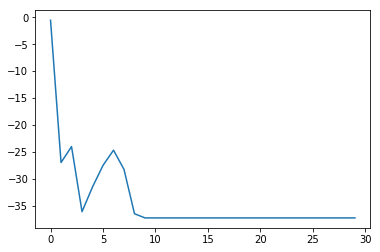

In [586]:
plt.plot([r2_score(y_test, np.std(preds[:i+1], axis=0)) for i in range(30)]);

The above plot suggests that adding more than 9 treest to our model will not enahnce our prediction, so we will go with the default 10 estimators

In [422]:
rmse(model.predict(X_train), y_train), rmse(model.predict(X_test), y_test)

(7532.790050159479, 22660.76888524281)

In [423]:
print('Training_Score: ', model.score(X_train, y_train))
print('Testing_Score: ', model.score(X_test, y_test))

Training_Score:  0.8203922191228753
Testing_Score:  -18.862545665919598


----

1. What are the most important features that affect the host revenue?
2. What is th emost popular neighborhood?
3. What is th emost popular type of property rental?
4. What are the most popular words that attract customers?

## Question 1: What are the most important features that affect the host revenue?

In [424]:
# Feature Importance
def feat_imp(m, df):
    return pd.DataFrame({'Features':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)

In [425]:
feat_imp = feat_imp(model, X_train)

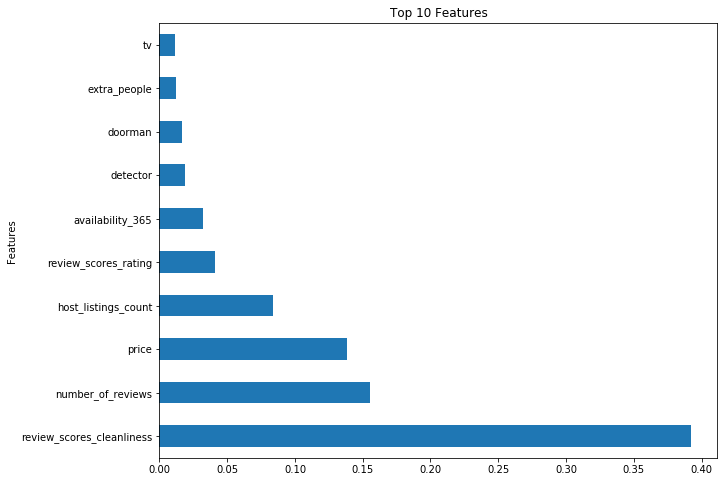

In [426]:
feat_imp[:10].plot('Features', kind='barh',title='Top 10 Features', figsize=(10, 8), legend=False)
plt.show()

In [427]:
data.description_count.mean()

AttributeError: 'DataFrame' object has no attribute 'description_count'

## Question 2: What is the most popular and most expensive neighborhoods in Seattle?

In [58]:
top_neighbour = df.groupby('neighbourhood_cleansed').price.agg(['mean', 'count'])
top_neighbour_price = top_neighbour.sort_values('mean', ascending =False).reset_index()[:10][['neighbourhood_cleansed', 'mean']]
top_neighbour_listings = top_neighbour.sort_values('count', ascending =False).reset_index()[:10][['neighbourhood_cleansed', 'count']]

In [59]:
# These are the most expensive neighborhoods in Seattle
top_neighbour_price

,neighbourhood_cleansed,mean
0,Southeast Magnolia,231.705882
1,Portage Bay,227.857143
2,Westlake,194.470588
3,West Queen Anne,187.769231
4,Montlake,182.789474
5,Briarcliff,176.571429
6,Sunset Hill,176.055556
7,Industrial District,173.333333
8,Alki,171.619048
9,Windermere,169.900000


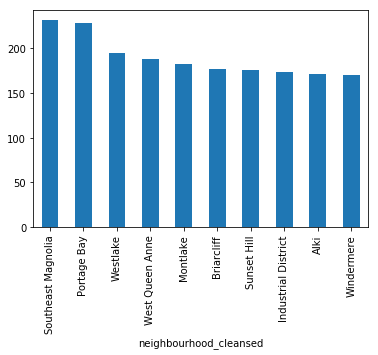

In [60]:
top_neighbour_price.plot(x='neighbourhood_cleansed', kind='bar', legend=False)
plt.show()

In [61]:
top = list(top_neighbour_price.neighbourhood_cleansed)

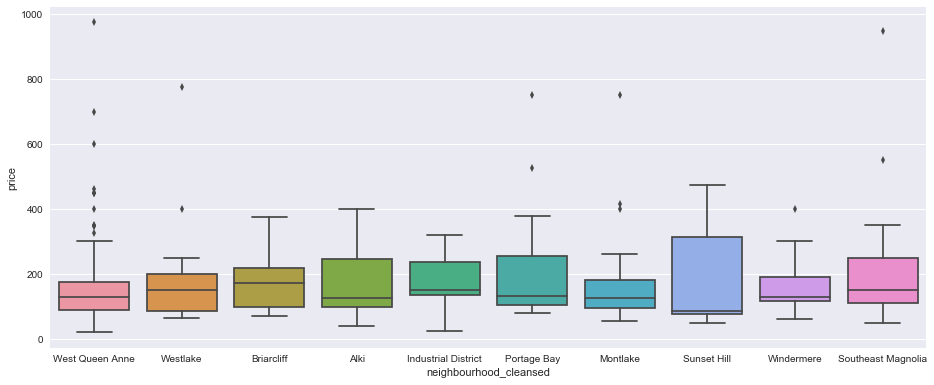

In [62]:
sns.set(rc={'figure.figsize':(15.7,6.27)})
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df[df.neighbourhood_cleansed.isin(top)])
plt.show()

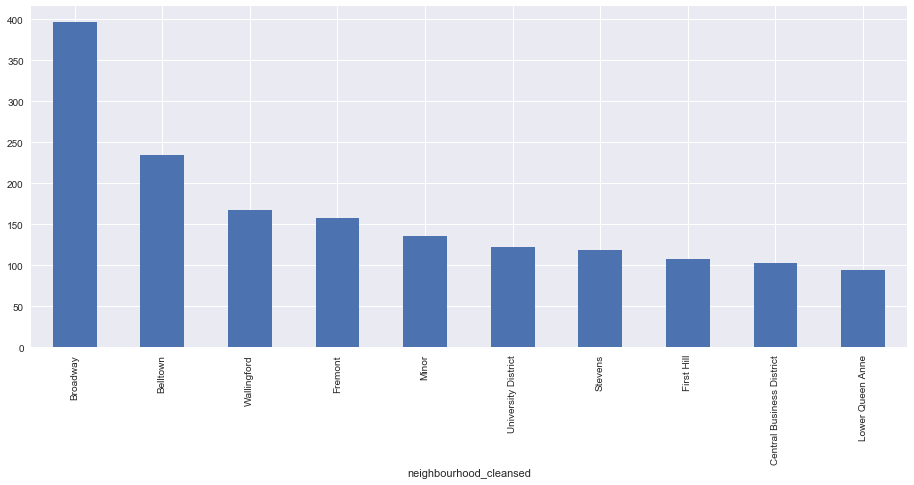

In [63]:
# These are the most popular in Seattle in terms f number of listing
top_neighbour_listings.plot(x='neighbourhood_cleansed', kind='bar', legend=False)
plt.show()

In [ ]:
    # The Amazing Text Variables
    # The below are a bit challenging because they are free text but definitly we can extract some useful keywords
    text_var = list(df[['summary', 'space', 'description', \
               'neighborhood_overview', 'notes', 'transit']].columns)
    
    # Before any treatment, I'll impute the missing variables in each record
    # I will impute with 'No Info' because this will help me track the value of these texts if useful
    df[text_var] = df[text_var].fillna('no info')
    
    # 1. Create a variable with the number of characters
    for col in text_var:
        df[col+'_size'] = df[col].str.len()
    
    # 2. Create size of distinct words
    for col in text_var:
        df[col+'_count'] = df[col].str.lower().str.split().str.len()
        
    # 3. Add frequency of top 10 words after dropping all the stopwords
    txt_vect = feature_extraction.text.TfidfVectorizer(max_features=10, stop_words='english')

    for col in text_var:
        matrix = txt_vect.fit_transform(df[col])
        matrix_df = pd.DataFrame(matrix.toarray(), columns=txt_vect.get_feature_names())
    
        for i in matrix_df:
            df[col+'_tf_'+str(i)] = matrix_df[i]    
        
    # Drop the existing variable    
    df.drop(columns=text_var, axis=1, inplace=True)